In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list names of anyone you worked with on this homework.

# [ERG 131] Homework 7: Resampling

The past two assignments (HW5 and HW6) focused on determining model coefficients using different methods (eg. ordinary least squares regression with scikit-learn, gradient descent). This assignment takes a step back, and explores resampling techniques. The point of resampling is to figure out how well a model will perform on data it hasn't seen yet. Generally when we resample, we use different combinations of the observation data to fit a bunch of models of the same form (eg. linear models) and we look at how the results differ from model to model. This process allows us to calculate values like the variance of our model coefficients or expected value of the mean squared error.

We've done a version of resampling in the past (lab 5) where we randomly subset our data into training and testing sets, but the resampling methods that we're covering now are more systematic than random subsets and are designed to ensure that all of the observations are included when training the models.

In this homework, you will work with the cross-validation method was introduced in lecture and in lab 7. 

A good reference here is ISLR Ch. 5.

### Table of Contents

1. [Overfitting](#of)<br>
1. [Cross Validation](#cv)<br> 
1. [Project](#proj)<br>

**Dependencies:**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

## Section 1: Overfitting <a name='of'></a>

In this class, we have been using mean squared error (MSE) as a way of quantifying error from our models, which is in the form:

$$
\text{MSE} = \frac{1}{n}\sum\limits_{i=1}^{n}\Big(y_i-\hat{f}(x_i)\Big)^2
$$

where $y_i$ is our target $y$ and $\hat{f}(x_i)$ is our estimator's best guess of the value $y$.

Our goal is to lower the MSE in our estimator model, but we risk overfitting if we minimize MSE on our data without considering how the model might perform on data that it hasn't seen before. As a basic example, we will try and choose a model with two parameters to fit linear data (with some noise added). By now, you should have a good idea of the variables that go into a linear model, and how to fine-tune them to decrease MSE.

We are going to create some pseudo-random data for the purposes of this homework. Read the block below before moving on and try to recite to yourself what each variable will represent. The answers for three of the variables are right below.

In [3]:
# Run this block
n = 50
sigma_2 = 100
noise = np.random.normal(scale=np.sqrt(sigma_2), size=n)
X = np.random.uniform(-10, 10, n)
Y = 100 + 20. * X  - 2 * X**2 - 0.3 * X**3
Y_obs = Y + noise

* `n` is the number of datapoints in our space.
* `X` is the x-values of our data
* `Y` is the non-biased estimator of our data (i.e. our response variable without any noise added). The model will roughly take its shape, but with a bit of added noise.

**Question 1.1:** Explain in 1-3 sentences what this line of code does. What do each of the arguments mean? How is the variable defined in this line used later on, and why is it important?

```python
np.random.normal(scale=np.sqrt(sigma_2), size=n)
```

*Hint:* This [link](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.normal.html) may help you.

*Your answer here*

** EXAMPLE ANSWER **
* This line generates `n` values drawn from a normal distribution with a standard deviation of `sigma_2` squared (i.e. a variance of `sigma_2`).
* We use the variable defined by those code (`noise`) when defining `Y_obs`, which is equal to the unbiased estimator `Y` (which is defined by the "real" model that represents the relationship between `Y` and `X`) with `noise` added. It allows us to simulate observations of Y.

We've now set up an experiment where we know the relationship beteen `Y` and `X`, but we're going to try to predict that relationship using `Y_obs`, which are our observed values of `Y`. Let's start the prediction process with a visualization.


**Question 1.2:** Create a scatterplot of the values of `X` and `Y_obs`. You may need to make the dots smaller (or the plot bigger) to avoid too much crowding of datapoints. Be sure to give your plot a title.

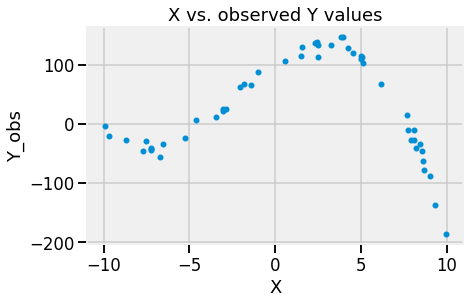

In [5]:
# ANSWER
plt.scatter(X,Y_obs, s = 20)
plt.xlabel('X')
plt.ylabel('Y_obs')
plt.title('X vs. observed Y values');

**Question 1.3:** When fitting the coefficients to figure out the relationship between `Y_obs` and `X`, we'll start with a general model form. Below is the formula for a second-order model with three parameters.

$$ \Large
y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2
$$

In the block below, describe in one sentence what each variable represents. The first one is done as an example:

**ANSWER**:

* $y_i$: This is the estimated value of the true y based on our model's parameters.
* $\beta_0$: YOUR ANSWER HERE
* $\beta_1$: YOUR ANSWER HERE
* $\beta_2$: YOUR ANSWER HERE
* $x_i$: YOUR ANSWER HERE

** EXAMPLE ANSWER: **

* $\beta_0$: This is the intercept of the model estimator.
* $\beta_1$: This is the coefficient of the term $x^1$ in the model estimator.
* $\beta_2$: This is the coefficient of the term $x^2$ in the model estimator.
* $x_i$: For each $i$ in the domain of our data, this is the x-value at that point. It is also referred to as a feature.

Now that we have a good grasp of what our dataset represents, we are going to try and find a model that best reproduces the relationship between $x$ and $y$. To do this, we need to split our data into train and test sets.

**Question 1.4:** Below, take our data `X` and `Y_obs` and create new data arrays for our new training and test sets. There should be 60% data inside of our training set, and 40% data in our test set. Use the `train_test_split()` function in the `sklearn.model_selection` library (also used in lab 7) with a random state of 1.

In [7]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X,Y_obs, test_size=0.4, random_state = 1)
assert [np.size(X_train), np.size(y_train)] == [30, 30]


**Question 1.5** Create a function, `scatter()`, that plots the training and testing data on the same scatter plot. As input, it should take in `X_train`, `X_test`, `y_train`, `y_test`, and a title. This will be useful later on, when we'll be outputting the scatter plot but overlaying different model fit lines on it - it will help as avoid copy-pasting code.

Use different markers or marker colors to denote training and testing data, and add a legend, axis labels, and a title (the title should change based on the input to the function).

After you've defined your function, call it in the second cell to produce a scatter plot of training and testing data.

In [10]:
# solution
def scatter(X_train, X_test, y_train, y_test, title):
    plt.scatter(X_train, y_train, c='lightseagreen', s=20, label = "training")
    plt.scatter(X_test, y_test, c='goldenrod', s=20, label = "testing")
    plt.legend()
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y_obs");

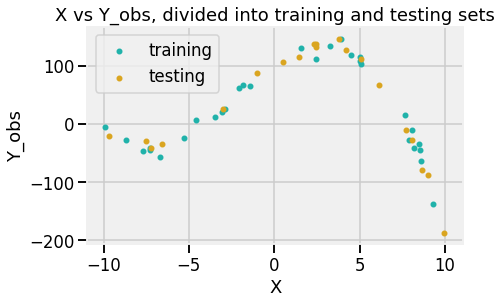

In [11]:
scatter(X_train, X_test, y_train, y_test, "X vs Y_obs, divided into training and testing sets")

It's time to fit our first model! What if we weren't sure what the general model form looked like? Normally, you'd start with the most simple model and improve from there. So, that is exactly what we will do - we will create a feature matrix $\Phi$. $\Phi$ is a matrix with $d$ columns, where each column contains the values of $X$ raised to a power from 1 to $d$. The general form of $\Phi$ looks like this:

$$ \large
\Phi_d(x) = \left[x, x^2, \ldots, x^d \right]
$$

For a first order model, $d$ would be equal to 1 and $\Phi$ would look like this:

$$ \large
\Phi_1(x) = \left[x \right]
$$

Depending on how many features (degrees) we are adding to our model, we account for it using the following function:

In [12]:
def poly_phi(d, X):
    #return lambda X: np.array([X ** i for i in range(1, k+1)]).T
    return np.array([X ** i for i in range(1, d+1)]).T

Before applying the function `poly_phi()` to our data, let's create a simple array `X_sample`. Run the cell below and make sure you understand how `poly_phi()` is working. Try changing the value for `d` to see how the output matrix changes for different degree values.

In [13]:
X_sample = np.array([1,2,3])

poly_phi(1,X_sample)

array([[1],
       [2],
       [3]])

**Question 1.6**: Define a function `lm_phi()` that performs a linear regression using a $\Phi_d$ matrix. As input, it should take X_train, X_test, y_train, y_test, and d (the degree of matrix $\Phi_d$). It should produce a scatter plot of the training and testing data (using the function `scatter()`) with a curve overlayed that shows the result of the linear regression, and it should return the mean squared error of the test data and of the training data.

*Hint*: Here's the documentation for the `LinearRegression` object again: [docs](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

*Hint*: When it comes to plotting a the curve of a model in matplotlib, it sometimes make sense to create a range of `X` values, `X_plot`, then generate predictions for each of those. If you generate predictions for your `X_test` values and plot those, matplotlib will basically "connect the dots", but since the `X_test` values aren't sorted, you'll end up with a plot that has lines crossing each other. If, instead, you define a range of values `X_plot`, then generate predictions for each of those, you'll get a curve - matplotlib is still connecting the dots, but now that it's been given a sequential set of values, it will do so in a way that actually reflects the shape of the function. To get you started, we've defined a variable `X_plot` below that you can use to generate predictions.<br>

When you calculate the test MSE, however, you should be using `X_test` (and getting predictions based on those values) rather than `X_plot`.

In [15]:
# SOLUTION
def lm_phi(d, X_train, X_test, y_train, y_test):
    phi_train = poly_phi(d, X_train)
    
    lm = LinearRegression()
    lm.fit(phi_train, y_train)
    
    X_plot = np.linspace(np.min(X_test), np.max(X_test), 200)

    y_pred = lm.predict(poly_phi(d, X_plot))
    
    title = 'Order-{} Linear Model on Train and Test Data'.format(d)
    scatter(X_train, X_test, y_train, y_test, title)
    plt.plot(X_plot, y_pred, c = "mediumvioletred");

    MSE_test = (1/len(X_test))*np.sum((lm.predict(poly_phi(d, X_test))-y_test)**2)
    MSE_train = (1/len(X_train))*np.sum((lm.predict(poly_phi(d, X_train))-y_train)**2)
    
    return MSE_test, MSE_train

**Question 1.7**: Call `lm_phi()` with `d = 1` to fit a model using the $\Phi_1$ matrix. Print the testing and training MSEs.

Your figure will look something like this:
<img src='lm_17.png' width="50%" height="50%"></img>

test MSE: 8975.580017927821
training MSE: 5228.197375095215


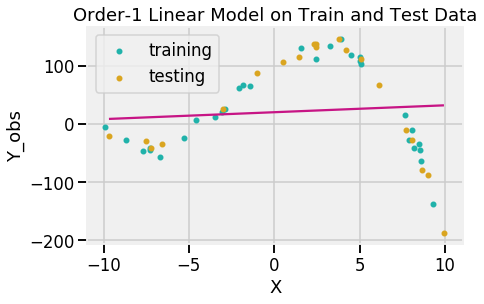

In [17]:
# solution
MSE_test, MSE_train = lm_phi(1, X_train, X_test, y_train, y_test)
print("test MSE:", MSE_test)
print("training MSE:", MSE_train)

Fitting the model with `d = 1` is a good start, but we're **underfitting** the model - we're not quite capturing the underlying trend of the data when we fit just the one feature. How do we fix this?

Let's try a different approach: instead of fitting just one feature, we'll fit as many as possible. Let's try creating a 24th-order polynomial estimator. 

**Question 1.8**: Call `lm_phi()` with `d = 24` to fit a model using the $\Phi_{24}$ matrix. Print the testing and training MSEs. After you've called `lm_phi()`, try using `plt.ylim()` to "zoom in and out" of your plot and get a better look at how the model varies with `X`, and output the plot with the y axis limits that best show how the model is responding to the training data.

test MSE: 685166245.9031082
training MSE: 1069.4219057795603


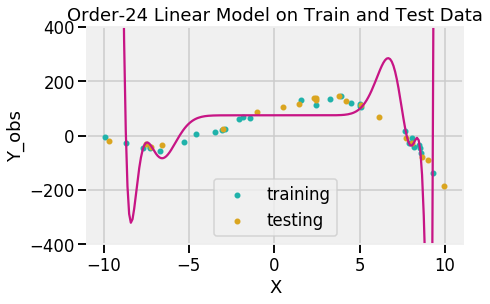

In [18]:
MSE_test, MSE_train = lm_phi(24, X_train, X_test, y_train, y_test)
plt.ylim(-400,400)

print("test MSE:", MSE_test)
print("training MSE:", MSE_train)

**Question 1.8** How did the values for training and test MSE change when you changed your feature matrix from having one column (`d = 1`) to 24 columns (`d = 24`)? Why did the MSE values change in this way?

*Your answer here*

Possible answer: when `d = 1`, the training MSE is slightly lower than the test MSE. When `d = 24`, the test MSE increases a lot (by about 500 times!) and the training MSE decreases (it's about 4 times smaller). This happens because when we add more features to our model and train it on just the training data, we end up with a model that's a much a closer fit to the training data but, as a result, the model performs poorly when it sees new data - it's not very generalizable.

**Question 1.9** Try running `lm_phi()` with different values for `d`. Choose the model that provides (visually and based on MSE values) the best fit of training and testing data. 

*Note*: you don't have to systematically loop through all values for `d` and choose the optimal one - we'll do that in the next section. You can just try different values for `d` and settle for one - you will probably find that there's a small range of values for `d` that give roughly similar model fits.

(60.791065725766025, 101.75312961809686)

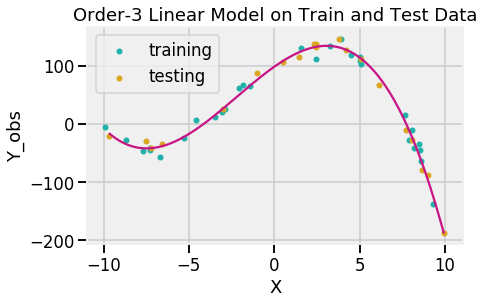

In [20]:
lm_phi(3, X_train, X_test, y_train, y_test)
# values between ~3-9 all give similar, reasonable curves

----

## Section 2: Cross Validation<a name='cv'></a>

You have now estimated the best fit for the data we created. Let's think about the steps we took to get to a successful answer: 

1. First, we started with a simple first-order polynomial to have a baseline to our training error.
1. We noticed from our graphing that it was insufficient, so we continued to add more features...
1. ... until we reached a point in which both the training data and the test data would both be well-fit with the number of features we have chosen.

In Section 1, we took a random sample of the data for training and a random sample for testing, and evaluated how the model, which was trained on the training data, performed on the testing data. But when we're trying to figure out how well our model will perform with new data, it's often not enough to get the MSE from just one random split into training and testing data. When we do a single split and train the model on a random subset of the data, we run the risk of over- or under-estimating the model error based on which observations made it into the training sets.

**k-fold cross validation** is a systematic way to make sure that we train the model at least once on every point in the dataset.

<img src='kfoldcv.png' width="50%" height="50%"></img>

The figure above, from ISLR pg. 181, shows an example of 5-fold cross validation. A k-fold cross validation algorithm randomly splits the data into k groups, ensuring that they're non-overlapping (i.e. each of the k groups has a validation set, and each validation set contains a distinct set of observations). In the figure above, each beige section represents about a fifth of the data set, and the model is fit 5 times with the remaining 4/5 of the data. We'll end up with 5 values for MSE, and we can calculate metrics like the average MSE or the variance of MSE to assess how the model responds to new data.

**Question 2.1:** Let's practice splitting training data into k-folds for validation purposes. Split the array `X` from section 1 into 3 folds, shuffling before we add the batches, with a random state of 7. For each fold, print the indices of the Train and Validation sets onto the console.

In [22]:
kf = KFold(n_splits = 3, shuffle = True, random_state = 7)

fold = 1
for train_i, val_i in kf.split(X):
    print("Fold", fold)
    print("Train:", train_i, "Test:", val_i, '\n')
    fold+=1

Fold 1
Train: [ 0  2  3  4  5  6  7  8  9 11 12 14 16 19 21 23 24 25 26 28 31 33 37 38
 39 40 41 43 44 45 47 48 49] Test: [ 1 10 13 15 17 18 20 22 27 29 30 32 34 35 36 42 46] 

Fold 2
Train: [ 1  3  4  7  8 10 13 14 15 17 18 19 20 22 23 25 26 27 28 29 30 32 34 35
 36 39 42 43 44 46 47 48 49] Test: [ 0  2  5  6  9 11 12 16 21 24 31 33 37 38 40 41 45] 

Fold 3
Train: [ 0  1  2  5  6  9 10 11 12 13 15 16 17 18 20 21 22 24 27 29 30 31 32 33
 34 35 36 37 38 40 41 42 45 46] Test: [ 3  4  7  8 14 19 23 25 26 28 39 43 44 47 48 49] 



You'll notice that each test set is distinct from the others, meaning that none of the test sets share common items even though they are shuffled pretty well. Let's think back to what we were doing in Problem #1. We were trying to figure out which model best fit both the training and test sets. However, we won't always be able to rely on just visualization for all cases. This is where k-fold and what you learned comes in!

**Question 2.2:** Let's do a little review first before you start implementing the k-fold CV. Recall the formula for mean squared error (MSE). Implement the function below to calculate the mean squared error between an array of predicted and true y-values.

In [24]:
# ANSWER
def mse(y_pred, y_true):
    return np.mean((y_pred - y_true)**2)

Recall back to the start of this homework when you tried different numbers of features to train models. We can use k-fold to find out which one has the lowest mean squared error when predicting y-values. Let's define an array, `d_array`, of possible `d` values to evaluate:

In [25]:
# run this cell
d_array = np.arange(1,24)

**Question 2.3:** Complete the function `mse_k_fold_lr` below. We are seeking to create a new k-fold cross validation pipeline with a number of folds given by input `n` , shuffling, and a random state given by the integer input `rand_state`. Remember, we are only splitting the training set into k-folds. Then, find the average mse for each validation split. The function should return the average of the MSEs for each number of parameters as a dictionary, with each key as a number representing the parameter size, and the value being the n-fold average of the MSEs. The dictionary should be saved in a variable called `average_mses`.<br>

This is a somewhat long function, but the code skeleton is written for you - focus on understanding what each step is trying to achieve (from the comments and from your understanding of k-fold cross-validation) and filling in code where you see ellipses (...).

In [27]:
# ANSWER
def mse_k_fold_lr(n, d_array, poly_phi, mse, X, y, rand_state):
    '''This function will print the d (degree) value that gives the smallest MSE.
    Returns the dictionary of average MSEs (from 3-fold cross validation) across the specified d values
    '''
    
    # 1. K-Fold where k = n
    kf = KFold(n_splits = n, shuffle = True, random_state = rand_state)
    
    # 2. Save the MSEs of each split.
    mses = np.zeros((n,len(d_array)))
    # every row of mses corresponds to one of the folds
    # every column of mses corresponds to one of the possible d values in d_array
    # for example, mses[0,0] corresponds to the mean squared error for the first fold, using d = 1 (the first element of d_array)
    
    fold = 0 # initialize fold value
    for train_i, val_i in kf.split(X):
        # 2.1 Separate X and Y_obs array into respective variables
        X_fold_train = X[train_i]
        y_fold_train = y[train_i]
        X_fold_val = X[val_i]
        y_fold_val = y[val_i]
        
        # 2.3 Each d value will receive its own LinearRegression() model.
        for i in range(len(d_array)):
            # 2.3.1 Create the model
            model = LinearRegression()
            
            # 2.3.2 Fit the data on a feature matrix with number of degrees equal to d[i] and the y_fold_train
            model.fit(poly_phi(d_array[i], X_fold_train), y_fold_train)
            
            # 2.3.3 Predict y-values for the test set transformed into a feature matrix
            y_pred = model.predict(poly_phi(d_array[i],X_fold_val))
            
            # Saving each mse between y_pred and y_fold_val at their respective fold and d value
            mses[fold,i] = mse(y_pred,y_fold_val)
        
        fold += 1 # augment the fold count
    
    # 3. Now, find the average of the MSEs for each d value. This should give you
    # .  the average of MSEs on 3 different val sets per each basis size.
    average_mses = {}
    for i in range(len(d_array)):
        average_mses[d_array[i]] = np.mean(mses[:,i])
    
    # 4. Find the index of the minimum average MSE
    min_mse_index = min(average_mses, key=average_mses.get)
    
    print("Minimum MSE Parameters:", min_mse_index, '\n',
          "MSE of {} Parameters:".format(min_mse_index), average_mses[min_mse_index])
    return average_mses


average_mses = mse_k_fold_lr(3, d_array, poly_phi, mse, X_train, y_train, 7)
average_mses

Minimum MSE Parameters: 3 
 MSE of 3 Parameters: 130.61769997934908


{1: 6105.210427694445,
 2: 3038.494298332258,
 3: 130.61769997934908,
 4: 141.25472494134075,
 5: 250.51961830103937,
 6: 339.7607836184783,
 7: 458.6138054842531,
 8: 447.3038809053592,
 9: 1582.1577945357592,
 10: 21176.98808024603,
 11: 30389.21832183981,
 12: 100582.67052763536,
 13: 3301988.5844293474,
 14: 1917511.850384812,
 15: 2940215.2215665677,
 16: 5463100.91562166,
 17: 1286199410.5876534,
 18: 1004062699.1987982,
 19: 2255641612.504452,
 20: 61071599029.43827,
 21: 41524711218.72706,
 22: 900481949980.1927,
 23: 82594651370.8578}

**Question 2.4** The function call above, for 3-fold cross validation on the training data with a random state of 7, should have returned a minimum MSE parameters of 3, with an MSE of about 130. In the cell below, try calling `mse_k_fold_lr()` but:

* changing the `rand_state` input but keeping `n` constant
* changing `n` to a larger value, and trying different values of `rand_state`

Then, answer the following questions:

* What are you changing in terms of the implementation of k-fold CV when you change `n`? How about when you change `rand_state`?
* Do the results (minimum MSE parameters and associated MSE) change when you vary `n` or `rand_state`?

*Your answer here*

In [29]:
# possible solution 
# changing rand_state but keeping n constant
mse_k_fold_lr(3, d_array, poly_phi, mse, X_train, y_train, 100)
mse_k_fold_lr(3, d_array, poly_phi, mse, X_train, y_train, 2)
mse_k_fold_lr(3, d_array, poly_phi, mse, X_train, y_train, 15);

Minimum MSE Parameters: 3 
 MSE of 3 Parameters: 120.48970263269182
Minimum MSE Parameters: 3 
 MSE of 3 Parameters: 134.36609848493663
Minimum MSE Parameters: 3 
 MSE of 3 Parameters: 117.92291313728299


In [30]:
# trying different values for n
mse_k_fold_lr(9, d_array, poly_phi, mse, X_train, y_train, 1)
mse_k_fold_lr(5, d_array, poly_phi, mse, X_train, y_train, 1)
mse_k_fold_lr(10, d_array, poly_phi, mse, X_train, y_train, 1);

Minimum MSE Parameters: 3 
 MSE of 3 Parameters: 129.2589091027291
Minimum MSE Parameters: 3 
 MSE of 3 Parameters: 126.39417669923473
Minimum MSE Parameters: 3 
 MSE of 3 Parameters: 130.101364325445


Possible answer: Changing n changes the number of folds, and changing rand_state changes the observations that are included in each train/validation split. The results seem pretty consistent! Whether we vary the number of folds (n) or the observations in each split (rand_state), we get a minimum MSE parameters of 3 with roughly similar MSEs. 

**Question 2.5:** Use the `matplotlib` or `seaborn` libraries to visualize the average *ROOT* mean squared error (RMSE) from cross-validating and to confirm your answer to Question 2.3. Use `n` = 3, `rand_state` = 7. Your plot should have a marker where the RMSE is minimized, and should have axis labels and a title.

*Hint*: you may want to plot the log of the RMSE to clearly display the full range of RMSE values

*Hint*: you can extract values from a dictionary using `.values()`, and can convert dictionary values to a list using `list()`.

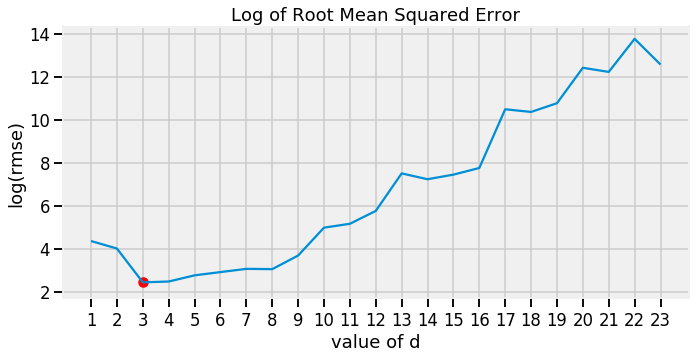

In [32]:
# EXAMPLE ANSWER
# There are multiple correct answers to this question.
log_root_average_mses = np.log(np.sqrt(list(average_mses.values())))

plt.figure(figsize = (10,5))
plt.plot(d_array, log_root_average_mses)
plt.xticks(d_array)
plt.scatter(3, log_root_average_mses[3], c='r')
plt.title('Log of Root Mean Squared Error')
plt.xlabel('value of d')
plt.ylabel('log(rmse)');

----

## Section 3: Project<a name='proj'></a>

**Question 3.1** A step that can help in defining a project is writing down your response (dependent) and your feature/predictor (independent) variables. 

At this point, what do you think your response variable will be (i.e. what your model is trying to predict)? Does it already exist in a dataset in the form that you need it, or is it a field that you'll need to calculate? (For example, my model might be predicting a value on an annual scale, but my data is on a monthly scale; in that case I'd need to calculate my response variable). If you're choosing between a few options at this point, you can discuss more than one potential response variable.

What are some features that you might include in your model? Are there any features that you want to include, but you haven't figured out where to get or how to calculate the data?

*Your answer here*

**Question 3.2** Based on your answer to the question above, try to think about what constitutes an "ideal" observation of your data. Try to write out your data in the form

$$y_i = f(x_{1i}, x_{2i},...)$$

where $y_i$ is your response variable and $x_{1i}, x_{2i},...$ are your features. What is $y$? What is What are $x_{1i}, x_{2i},...$? What is $i$ indexing in your case?

As an example, if we were to answer the questions above for the Novotny et al. paper, we would get:<br>
$y$ is atmospheric $NO_2$ measurements<br>
$x_1$ is % impervious surface<br>
$x_2$ is % tree canopy<br>
$x_3$ is population<br>
$x_4$ is major road length<br>
$x_5$ is minor road length<br>
$x_6$ is total road length<br>
$x_7$ is elevation<br>
$x_8$ is distance to coast<br>
$x_9$ is ground-based OMI $NO_2$ measurement,<br>
and $i$ is indexing US Census Blocks - i.e. each observation is for a different census block

*Your answer here*

**Question 3.3** Choose two variables of interest from your dataset and visualize the relationship between them using whatever type of plot makes the most sense. Ideally, you would be able to explore the relationship between one of your predictors and your response variable, but if your response isn't finalized yet, you can take this as an opportunity to look at the relationship between any two interesting variables.

Comment on your plot - is the trend interesting, expected, or surprising at all?

*Your answer here*